In [1]:
from datasets import load_dataset
emotions = load_dataset("emotion")
emotions

Generating train split:   0%|          | 0/16000 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/2000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/2000 [00:00<?, ? examples/s]

Dataset emotion downloaded and prepared to /root/.cache/huggingface/datasets/emotion/default/0.0.0/348f63ca8e27b3713b6c04d723efe6d824a56fb3d1449794716c0f0296072705. Subsequent calls will reuse this data.


  0%|          | 0/3 [00:00<?, ?it/s]

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 16000
    })
    validation: Dataset({
        features: ['text', 'label'],
        num_rows: 2000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 2000
    })
})

In [2]:
# load tokenizer from AutoTokenizer
from transformers import AutoTokenizer
model_ckpt = "distilbert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_ckpt)

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/483 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/455k [00:00<?, ?B/s]

In [3]:
def tokenize(batch):
    return tokenizer(batch["text"], padding=True, truncation=True)

In [7]:
emotions_encoded = emotions.map(tokenize, batched=True, batch_size=None)
emotions_encoded.set_format("torch", columns=["input_ids", "attention_mask", "label"])
emotions_encoded

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

DatasetDict({
    train: Dataset({
        features: ['text', 'label', 'input_ids', 'attention_mask'],
        num_rows: 16000
    })
    validation: Dataset({
        features: ['text', 'label', 'input_ids', 'attention_mask'],
        num_rows: 2000
    })
    test: Dataset({
        features: ['text', 'label', 'input_ids', 'attention_mask'],
        num_rows: 2000
    })
})

In [14]:
emotions_encoded["train"]['attention_mask'].shape

torch.Size([16000, 87])

In [5]:
import torch
from transformers import AutoModel

model_ckpt = "distilbert-base-uncased"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = AutoModel.from_pretrained(model_ckpt).to(device)

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Downloading:   0%|          | 0.00/256M [00:00<?, ?B/s]

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_transform.weight', 'vocab_layer_norm.weight', 'vocab_layer_norm.bias', 'vocab_transform.bias', 'vocab_projector.bias', 'vocab_projector.weight']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [19]:
import torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [20]:
from transformers import AutoModelForSequenceClassification
num_labels = 6
model_ckpt = "distilbert-base-uncased"
model = AutoModelForSequenceClassification.from_pretrained(model_ckpt, num_labels=num_labels).to(device)

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_transform.weight', 'vocab_layer_norm.weight', 'vocab_layer_norm.bias', 'vocab_transform.bias', 'vocab_projector.bias', 'vocab_projector.weight']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['pre_classifier.weight', 'classifier.weight', 'classifi

In [21]:
from sklearn.metrics import accuracy_score, f1_score

def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.prediction.argmax(-1)
    f1 = f1_score(labels, preds, average="weighted")
    acc = accuracy_score(labels, preds)
    return {"accuracy": acc, "f1": f1}

### Extracting the last hidden states

In [6]:
text = "this is a test"
inputs = tokenizer(text, return_tensors="pt")
print(f"Input tensor shape: {inputs['input_ids'].size()}")
print(inputs)

Input tensor shape: torch.Size([1, 6])
{'input_ids': tensor([[ 101, 2023, 2003, 1037, 3231,  102]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1]])}


In [7]:
inputs = {k:v.to(device) for k,v in inputs.items()}
print(inputs)
with torch.no_grad():
    outputs = model(**inputs)
print(outputs)

{'input_ids': tensor([[ 101, 2023, 2003, 1037, 3231,  102]], device='cuda:0'), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1]], device='cuda:0')}
BaseModelOutput(last_hidden_state=tensor([[[-0.1565, -0.1862,  0.0528,  ..., -0.1188,  0.0662,  0.5470],
         [-0.3575, -0.6484, -0.0618,  ..., -0.3040,  0.3508,  0.5221],
         [-0.2772, -0.4459,  0.1818,  ..., -0.0948, -0.0076,  0.9958],
         [-0.2841, -0.3917,  0.3753,  ..., -0.2151, -0.1173,  1.0526],
         [ 0.2661, -0.5094, -0.3180,  ..., -0.4203,  0.0144, -0.2149],
         [ 0.9441,  0.0112, -0.4714,  ...,  0.1439, -0.7288, -0.1619]]],
       device='cuda:0'), hidden_states=None, attentions=None)


In [8]:
outputs.last_hidden_state.size()

torch.Size([1, 6, 768])

In [9]:
outputs.last_hidden_state[:, 0].size()

torch.Size([1, 768])

In [10]:
def extract_hidden_states(batch):
    # place model inputs on the GPU
    inputs = {k:v.to(device) for k, v in batch.items() if k in tokenizer.model_input_names}
    with torch.no_grad():
        last_hidden_state = model(**inputs).last_hidden_state
    return {"hidden_state": last_hidden_state[:, 0].cpu().numpy()}

In [11]:
emotions_encoded.set_format("torch", columns=["input_ids", "attention_mask", "label"])

In [12]:
emotions_hidden = emotions_encoded.map(extract_hidden_states, batched=True)

  0%|          | 0/16 [00:00<?, ?ba/s]

  0%|          | 0/2 [00:00<?, ?ba/s]

  0%|          | 0/2 [00:00<?, ?ba/s]

In [13]:
emotions_hidden["train"]["hidden_state"].shape

torch.Size([16000, 768])

In [14]:
import numpy as np
X_train = np.array(emotions_hidden["train"]["hidden_state"])
X_valid = np.array(emotions_hidden["validation"]["hidden_state"])
y_train = np.array(emotions_hidden["train"]["label"])
y_valid = np.array(emotions_hidden["validation"]["label"])
print(X_train.shape)
print(X_valid.shape)

(16000, 768)
(2000, 768)


### Logistic Regression

In [15]:
from sklearn.linear_model import LogisticRegression
lr_clf = LogisticRegression(max_iter=3000)
lr_clf.fit(X_train, y_train)
lr_clf.score(X_valid, y_valid)

0.634

In [16]:
from sklearn.dummy import DummyClassifier
dummy_clf = DummyClassifier(strategy="most_frequent")
dummy_clf.fit(X_train, y_train)
dummy_clf.score(X_valid, y_valid)

0.352

In [17]:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
import matplotlib.pyplot as plt

def plot_confusion_matrix(y_preds, y_true, labels):
    cm = confusion_matrix(y_true, y_preds, normalize="true")
    fig, ax = plt.subplots(figsize=(6, 6))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
    disp.plot(cmap="Blues", values_format=".2f", ax=ax, colorbar=False)
    plt.title("Normalized confusion matrix")
    plt.show()

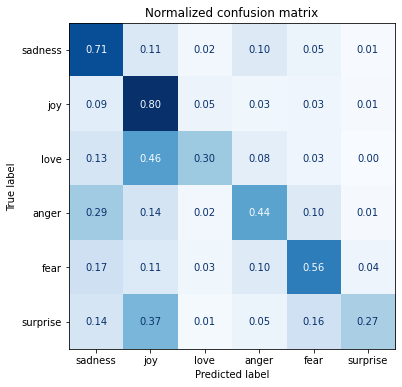

In [18]:
y_preds = lr_clf.predict(X_valid)
labels = emotions["train"].features["label"].names
plot_confusion_matrix(y_preds, y_valid, labels)

### Fine-tuning transformer

In [10]:
# from huggingface_hub import notebook_login
# notebook_login()

In [22]:
from transformers import Trainer, TrainingArguments

batch_size = 64
logging_steps = len(emotions_encoded["train"])
model_name = f"{model_ckpt}-finetuned-emotion"
training_args = TrainingArguments(
    output_dir=model_name,
    num_train_epochs=2,
    learning_rate=2e-5,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    weight_decay=0.01,
    evaluation_strategy="epoch",
    disable_tqdm=False,
    logging_steps=logging_steps,
    push_to_hub=False,
)

In [23]:
trainer = Trainer(
    model=model,
    args=training_args,
    compute_metrics=compute_metrics,
    train_dataset=emotions_encoded["train"],
    eval_dataset=emotions_encoded["validation"],
    tokenizer=tokenizer
)

trainer.train()

The following columns in the training set don't have a corresponding argument in `DistilBertForSequenceClassification.forward` and have been ignored: text. If text are not expected by `DistilBertForSequenceClassification.forward`,  you can safely ignore this message.
/opt/conda/lib/python3.7/site-packages/transformers/optimization.py:310: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,
***** Running training *****
  Num examples = 16000
  Num Epochs = 2
  Instantaneous batch size per device = 64
  Total train batch size (w. parallel, distributed & accumulation) = 128
  Gradient Accumulation steps = 1
  Total optimization steps = 250
Automatic Weights & Biases logging enabled, to disable set os.environ["WANDB_DISABLED"] = "true"
wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: ht

  ········································


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


/opt/conda/lib/python3.7/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


Epoch,Training Loss,Validation Loss


The following columns in the evaluation set don't have a corresponding argument in `DistilBertForSequenceClassification.forward` and have been ignored: text. If text are not expected by `DistilBertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 2000
  Batch size = 128


AttributeError: 'EvalPrediction' object has no attribute 'prediction'